In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:05, 1597.32it/s]


In [5]:
df = pd.DataFrame(responses)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


### Анализ текстов

#### 1. Кол-во отзывов в разных городах на разные банки

#### Приведем названия городов и банков к общему виду, чтобы избежать дублирований, таких как Спб, Питер, Санкт-петербург и т.д.

In [51]:
import re

In [88]:
def chenging_city(col): 
    if col is not None:
        city = col.lower().replace('_', '-')

        city = re.sub(r'[^а-яa-z -]', '', city)
        if city == 'г мск' or city == 'г moscow':
            city = 'г москва'
        if city == 'г спб' or city == 'г питер':
            city = 'г санкт-петербург'
    else:
        return col
    
    return city

def chenging_bank(col):
    bank = col.lower().replace('_', '-')
    bank = re.sub(r'[^а-яa-z -]', '', bank)
    return bank

In [89]:
df['city'] = df['city'].apply(chenging_city)
df['bank_name'] = df['bank_name'].apply(chenging_city)

In [103]:
amount_of_review = df.groupby(['city', 'bank_name'])['text'].agg('count').reset_index()

In [105]:
amount_of_review.sort_values(by='text', ascending=False, inplace=True)

In [120]:
amount_of_review.head(50)

,city,bank_name,text
7847,г москва,сбербанк россии,8328
7554,г москва,альфа-банк,3976
7835,г москва,русский стандарт,2905
7616,г москва,втб,2756
12813,г санкт-петербург,сбербанк россии,2554
7733,г москва,московский кредитный банк,2404
7888,г москва,тинькофф банк,2392
7925,г москва,хоум кредит банк,2193
7747,г москва,национальный банк траст,1695
7797,г москва,райффайзенбанк,1462


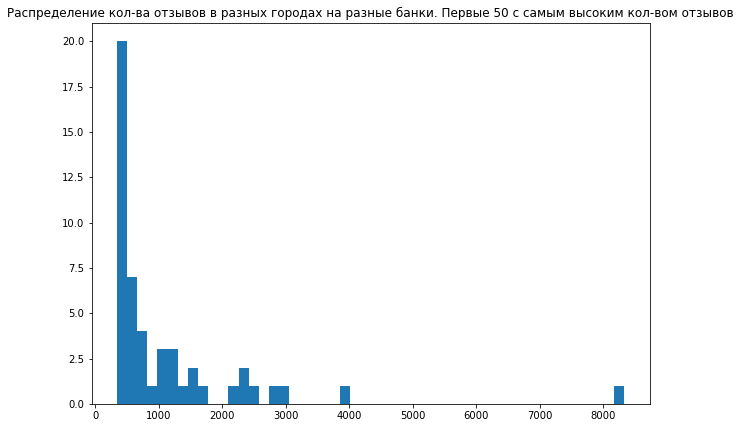

In [121]:
plt.figure(figsize=(10,7))
plt.hist(amount_of_review.head(50)['text'], bins=50)
plt.title('Распределение кол-ва отзывов в разных городах на разные банки. Первые 50 с самым высоким кол-вом отзывов')
print()

#### 2. Гистограмы длин слов в символах и в словах

In [249]:
def count_amount(col, dict_words, dict_signs):
    col = col.lower()
    col = re.sub(r'[^а-яa-z -]', '', col)
    
    # Добавляем значение в dict_words    
    count_of_words = col.split(' ')
    dict_words.append(len(count_of_words))
    
    # Добавляем значение в dict_signs
    for i in count_of_words:
        count_of_signs = len(i)
        # У нас есть пара выбросов со словами длинной за 700 символов, отфильтруем по длине
        if count_of_signs <= 50:
            dict_signs.append(count_of_signs)
            

In [250]:
dict_words = []
dict_signs = []

df['text'].apply(count_amount, dict_words=dict_words, dict_signs=dict_signs)
print()

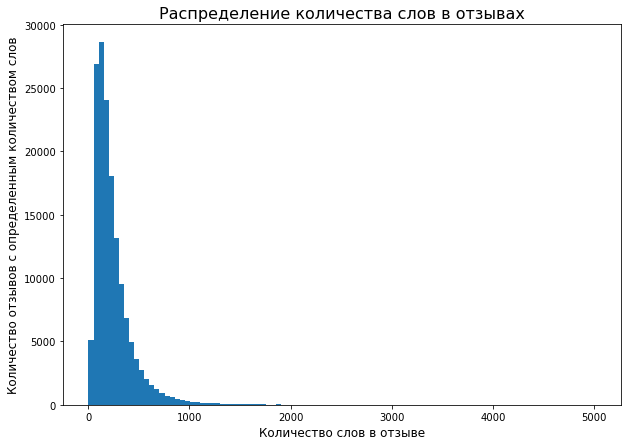

In [247]:
plt.figure(figsize=(10,7))
plt.hist(dict_words, bins=100)
plt.xlabel('Количество слов в отзыве', fontsize=12)
plt.ylabel('Количество отзывов с определенным количеством слов', fontsize=12)
plt.title('Распределение количества слов в отзывах', fontsize=16)

print()

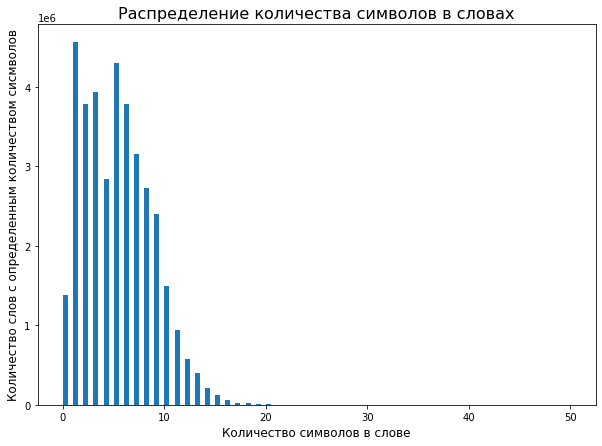

In [252]:
plt.figure(figsize=(10,7))
plt.hist(dict_signs, bins=100)
plt.xlabel('Количество символов в слове', fontsize=12)
plt.ylabel('Количество слов с определенным количеством сисмволов', fontsize=12)
plt.title('Распределение количества символов в словах', fontsize=16)

print()

#### 3. Найти самые частые:

In [253]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [254]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79028\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79028\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [264]:
pymorphy = MorphAnalyzer()

In [293]:
# Приведение к лемме библиотекой Pymorphy
def lemma_pymorphy(tokens, tagging):
    arr = []
    for i in tokens:
        lemma = pymorphy.parse(i)[0].normal_form
        if tagging == True:
            tag = str(pymorphy.parse(i)[0].tag.POS)
            arr.append(lemma+'_'+tag)
        else:
            arr.append(lemma)
    return arr

In [294]:
# Функция обработки текста
def text_processing(text, stopwords=False, lemma=False, tagging=False):
    text = text.lower()
    text = text.replace("ё", "е")
    text = re.sub(r'[^а-я a-z0-9 -]', '', text)
    
    tokens = word_tokenize(text)
    
    if stopwords == True:
        tokens = [i for i in tokens if (i not in stop_words)]
        
    if lemma == True:
        tokens = lemma_pymorphy(tokens, tagging)
        
    return tokens

In [361]:
df_words = df['text'].apply(text_processing)

In [367]:
corpus = []
def make_corpus(col, corpus):
    corpus.extend(col)

In [363]:
df_words.apply(make_corpus, corpus=corpus)
print()

In [311]:
from collections import Counter

In [364]:
freq_dict = Counter(corpus)

#### 10 самых частых слов

In [366]:
freq_dict.most_common(10)

[('в', 1322045),
 ('и', 1054053),
 ('не', 851361),
 ('на', 704004),
 ('что', 620704),
 ('я', 575008),
 ('с', 454713),
 ('по', 364933),
 ('мне', 320510),
 ('-', 295825)]

#### 10 самых частых слов без стопслов

In [368]:
df_not_stop = df['text'].apply(text_processing, stopwords=True)

In [369]:
corpus_not_stop = []
df_not_stop.apply(make_corpus, corpus=corpus_not_stop)
print()

In [370]:
freq_dict_not_stop = Counter(corpus_not_stop)

In [371]:
freq_dict_not_stop.most_common(10)

[('-', 295825),
 ('банка', 263711),
 ('банк', 196085),
 ('это', 182938),
 ('деньги', 130004),
 ('карту', 104904),
 ('карты', 100828),
 ('кредит', 80195),
 ('день', 75928),
 ('заявление', 69469)]

#### 10 самых частотных лемм

In [372]:
df_lemma_tag = df['text'].apply(text_processing, stopwords=True, lemma=True, tagging=True)

In [373]:
corpus_lemma = []
df_lemma_tag.apply(make_corpus, corpus=corpus_lemma)
print()

In [374]:
freq_dict_lemma = Counter(corpus_lemma)


In [496]:
freq_dict_lemma.most_common(10)

[('банк_NOUN', 623735),
 ('карта_NOUN', 331634),
 ('-_None', 295825),
 ('это_PRCL', 182938),
 ('деньга_NOUN', 178274),
 ('день_NOUN', 172547),
 ('мой_ADJF', 166952),
 ('кредит_NOUN', 154720),
 ('который_ADJF', 148774),
 ('отделение_NOUN', 143547)]

#### Сохраним данные на всякий случай

In [378]:
df_for_csv = df_lemma_tag.apply(lambda x: " ".join(x))

In [380]:
df_for_csv.to_csv('DataFrame_lemma_tag.csv')

#### 10 самых частотных существительных

In [469]:
def get_most_common_part_of_speech(dict_, amount=10, part='NOUN'):
    most_common = []
    i = 1
    while len(most_common) < amount:
        word = dict_.most_common(i)[-1][0]
        if re.search(r'_{}'.format(re.escape(part)), word):
            most_common.append(dict_.most_common(i)[-1])
        i+=1
    return most_common

In [470]:
get_most_common_part_of_speech(freq_dict_lemma)

[('банк_NOUN', 623735),
 ('карта_NOUN', 331634),
 ('деньга_NOUN', 178274),
 ('день_NOUN', 172547),
 ('кредит_NOUN', 154720),
 ('отделение_NOUN', 143547),
 ('счёт_NOUN', 140477),
 ('сотрудник_NOUN', 133507),
 ('клиент_NOUN', 132848),
 ('сумма_NOUN', 110788)]

#### 4. Кривые Ципфа и Хипса

#### Кривая Ципфа

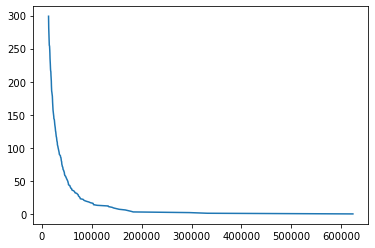

In [439]:
freqs = list(freq_dict_lemma.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

#### Кривая Хипса

In [466]:
arr = [0]
count = Counter()
for text in tqdm(df_lemma_tag):
    count.update(text)
    arr.append(len(count))

100%|███████████████████████████████████████████████████████████████████████| 153499/153499 [00:05<00:00, 28916.52it/s]


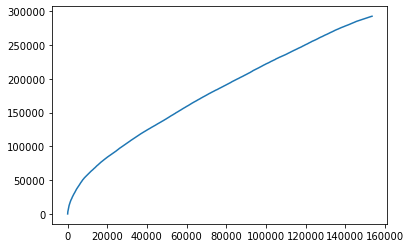

In [468]:
plt.plot(arr)

#### 5.

#### Какое слово встречается чаще, "сотрудник" или "клиент"
Как мы увидели выше, два этих слова попали в первую десятку по частотности существительных.
Сотрудник встречается 133507 раз, а Клиент чуть меньше - 132848 раз

#### Сколько раз встречается слова "мошенничество" и "доверие"

In [489]:
freq_dict_lemma['доверие_NOUN']

2101

In [490]:
freq_dict_lemma['мошенничество_NOUN']

3219

#### 6. Мера TFIDF , для поиска ключевых слов и биграмм для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


#### Соединим основной DF с лемматизированным текстом

In [7]:
df_lemma_tag = pd.read_csv('DataFrame_lemma_tag.csv')

In [9]:
df_lemma_tag.head(2)

,Unnamed: 0,text
0,0,добрый_ADJF день_NOUN являться_VERB клиент_NOU...
1,1,добрый_ADJF день_NOUN являться_VERB держатель_...


In [15]:
df['lemma_text'] = df_lemma_tag['text']

In [16]:
data = df[['rating_grade', 'lemma_text']][(df['rating_grade'] == 1.0) | (df['rating_grade'] == 5.0)]

In [17]:
data['rating_grade'].value_counts()

1.0    47387
5.0    14713
Name: rating_grade, dtype: int64

#### TFIDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
def get_keywords(data, num_to_print=20):
    vec = TfidfVectorizer()
    tfidf = vec.fit_transform(data)
    
    df = pd.DataFrame(tfidf[0].T.todense(), index=vec.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    
    print (df.head(num_to_print))
    
    return df

In [29]:
freq_negative = get_keywords(data_corp_negative, 10)

                     TF-IDF
доллар_noun        0.247499
рубдоллар_noun     0.234063
курс_noun          0.230321
546_none           0.212542
долларовый_adjf    0.196791
операционист_noun  0.190143
700_none           0.176824
операция_noun      0.175647
рубль_noun         0.165678
риторический_adjf  0.154834


In [30]:
freq_positive = get_keywords(data_corp_positive, 10)

                     TF-IDF
ленсовет_noun      0.330085
прикрыть_verb      0.276442
89_none            0.270365
озерко_noun        0.270365
вклад_noun         0.229087
нести_verb         0.209731
доступность_noun   0.198388
значительный_adjf  0.192258
заказать_infn      0.179920
заказывать_verb    0.179011


### Тематическое моделирование

In [573]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [577]:
texts = [text.split() for text in data['lemma_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [580]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#### 1. Несколько тематических моделей коллекции документов с разным числом тем. Сделал одинаковые модели с разным числом тем

In [579]:
from gensim.models import lsimodel

In [581]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 2min 9s


In [589]:
lsi.show_topics(10)

[(0,
  '0.190*"карта_NOUN" + 0.130*"кредит_NOUN" + 0.118*"-_None" + 0.108*"деньга_NOUN" + 0.107*"заявление_NOUN" + 0.106*"вклад_NOUN" + 0.105*"счёт_NOUN" + 0.101*"банкомат_NOUN" + 0.098*"отделение_NOUN" + 0.088*"сотрудник_NOUN"'),
 (1,
  '-0.586*"вклад_NOUN" + -0.155*"очередь_NOUN" + 0.147*"заявление_NOUN" + 0.116*"платёж_NOUN" + 0.116*"задолженность_NOUN" + 0.115*"кредит_NOUN" + 0.114*"банкомат_NOUN" + 0.104*"карта_NOUN" + 0.103*"претензия_NOUN" + -0.095*"очень_ADVB"'),
 (2,
  '-0.385*"кредит_NOUN" + 0.375*"банкомат_NOUN" + 0.286*"карта_NOUN" + -0.207*"страховка_NOUN" + -0.165*"договор_NOUN" + -0.147*"погашение_NOUN" + 0.146*"деньга_NOUN" + 0.142*"сбербанк_NOUN" + -0.140*"документ_NOUN" + 0.120*"операция_NOUN"'),
 (3,
  '0.431*"вклад_NOUN" + -0.259*"карта_NOUN" + -0.204*"заявка_NOUN" + 0.176*"сумма_NOUN" + 0.165*"банкомат_NOUN" + 0.147*"договор_NOUN" + 0.138*"средство_NOUN" + 0.133*"погашение_NOUN" + 0.131*"деньга_NOUN" + 0.127*"платёж_NOUN"'),
 (4,
  '0.490*"банкомат_NOUN" + -0.368*"

In [585]:
%%time
lsi_2 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

Wall time: 56.8 s


In [586]:
lsi_2.show_topics(5)

[(0,
  '0.190*"карта_NOUN" + 0.130*"кредит_NOUN" + 0.118*"-_None" + 0.108*"деньга_NOUN" + 0.107*"заявление_NOUN" + 0.106*"вклад_NOUN" + 0.105*"счёт_NOUN" + 0.100*"банкомат_NOUN" + 0.098*"отделение_NOUN" + 0.088*"сотрудник_NOUN"'),
 (1,
  '-0.586*"вклад_NOUN" + -0.155*"очередь_NOUN" + 0.144*"заявление_NOUN" + 0.118*"задолженность_NOUN" + 0.118*"кредит_NOUN" + 0.116*"платёж_NOUN" + 0.113*"банкомат_NOUN" + 0.103*"претензия_NOUN" + 0.102*"карта_NOUN" + -0.095*"открыть_INFN"'),
 (2,
  '-0.385*"кредит_NOUN" + 0.370*"банкомат_NOUN" + 0.290*"карта_NOUN" + -0.208*"страховка_NOUN" + -0.163*"договор_NOUN" + -0.147*"погашение_NOUN" + 0.144*"деньга_NOUN" + 0.140*"сбербанк_NOUN" + -0.139*"документ_NOUN" + -0.123*"страхование_NOUN"'),
 (3,
  '0.415*"вклад_NOUN" + -0.261*"карта_NOUN" + -0.199*"заявка_NOUN" + 0.181*"банкомат_NOUN" + 0.177*"сумма_NOUN" + 0.144*"договор_NOUN" + 0.144*"средство_NOUN" + 0.132*"погашение_NOUN" + 0.131*"деньга_NOUN" + 0.126*"процент_NOUN"'),
 (4,
  '0.418*"банкомат_NOUN" + -

#### 2. Темы с упоминанием конкретных банков

In [590]:
lsi.show_topics(10)[8]

(8,
 '0.333*"сбербанк_NOUN" + 0.308*"страховка_NOUN" + -0.261*"банкомат_NOUN" + 0.169*"очередь_NOUN" + 0.158*"страхование_NOUN" + 0.156*"перевод_NOUN" + -0.154*"звонок_NOUN" + -0.151*"претензия_NOUN" + -0.146*"заявка_NOUN" + -0.141*"вклад_NOUN"')

In [592]:
lsi.show_topics(20)[11]

(11,
 '-0.388*"сбербанк_NOUN" + -0.273*"терминал_NOUN" + -0.255*"платёж_NOUN" + 0.173*"счёт_NOUN" + 0.160*"комиссия_NOUN" + -0.154*"вклад_NOUN" + -0.154*"заявка_NOUN" + 0.149*"справка_NOUN" + -0.134*"кредит_NOUN" + 0.130*"банкомат_NOUN"')

In [593]:
lsi.show_topics(20)[12]

(12,
 '0.323*"заявка_NOUN" + 0.219*"очередь_NOUN" + -0.200*"сбербанк_NOUN" + -0.199*"мы_NPRO" + -0.183*"сделка_NOUN" + -0.168*"квартира_NOUN" + 0.149*"минута_NOUN" + 0.139*"касса_NOUN" + -0.133*"деньга_NOUN" + -0.124*"карточка_NOUN"')

## Классификация текстов

#### 1. Разбиение на train и test

In [621]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import  train_test_split

In [600]:
x_train, x_test, y_train, y_test = train_test_split(data['lemma_text'], data['rating_grade'], test_size=0.3, random_state=42)

#### 2. Стандартная модель на tf-idf

#### Baseline

In [602]:
vec = TfidfVectorizer()

In [604]:
vec.fit(x_train)
x_train_tfidf = vec.transform(x_train)
x_test_tfidf = vec.transform(x_test)

In [605]:
model = LogisticRegression()
model.fit(x_train_tfidf, y_train)

LogisticRegression()

In [612]:
y_pred = model.predict(x_test_tfidf)

In [615]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98     14665
         5.0       0.87      0.97      0.92      3965

    accuracy                           0.96     18630
   macro avg       0.93      0.97      0.95     18630
weighted avg       0.97      0.96      0.96     18630



#### Baseline на уни и биграммах

In [617]:
vec_2 = TfidfVectorizer(ngram_range=(1,2))

vec_2.fit(x_train)
x_train_tfidf_2 = vec_2.transform(x_train)
x_test_tfidf_2 = vec_2.transform(x_test)

In [619]:
model_2 = LogisticRegression()
model_2.fit(x_train_tfidf_2, y_train)

y_pred_2 = model_2.predict(x_test_tfidf_2)

In [620]:
print(classification_report(y_pred_2, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97     14868
         5.0       0.83      0.98      0.90      3762

    accuracy                           0.96     18630
   macro avg       0.91      0.96      0.94     18630
weighted avg       0.96      0.96      0.96     18630



#### В таком варианте немногим хуже

#### 3. Использование скрытых тем

In [622]:
from sklearn.decomposition import TruncatedSVD

In [632]:
f1_scores = []
n_components = []


for i in tqdm(range(50, 310, 10)):
    decomp = TruncatedSVD(n_components=i, random_state=0)
    decomp.fit(x_train_tfidf)
    
    x_train_reduced = decomp.transform(x_train_tfidf)
    x_test_reduced = decomp.transform(x_test_tfidf)
    
    model_with_svd = LogisticRegression()
    model_with_svd.fit(x_train_reduced, y_train)
    
    y_pred_svd = model_with_svd.predict(x_test_reduced)
    f1 = f1_score(y_pred_svd, y_test)
    
    f1_scores.append(f1)
    n_components.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [11:08<00:00, 25.70s/it]


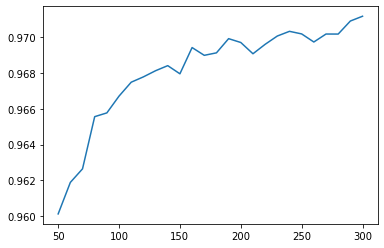

In [636]:
plt.plot(n_components, f1_scores)

In [638]:
from sklearn.decomposition import LatentDirichletAllocation

In [646]:
LDA = LatentDirichletAllocation(n_components=50)
LDA.fit(x_train_tfidf)
x_train_lda = LDA.transform(x_train_tfidf)
x_test_lda = LDA.transform(x_test_tfidf)

In [647]:
model_with_lda = LogisticRegression()
model_with_lda.fit(x_train_lda, y_train)
    
y_pred_lda = model_with_lda.predict(x_test_lda)
print(classification_report(y_pred_lda, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.76      0.86     18630
         5.0       0.00      0.00      0.00         0

    accuracy                           0.76     18630
   macro avg       0.50      0.38      0.43     18630
weighted avg       1.00      0.76      0.86     18630



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
